In [1]:
import pandas as pd
from utils.data import get_data

metabric_path = "data/METABRIC_CLIN_GE_CNA.csv"

# Load METABRIC
complete_data = pd.read_csv(metabric_path, index_col=None, header=0, low_memory=False)
# Remove unknown classes
complete_data = complete_data.drop(
    complete_data[complete_data["Pam50Subtype"] == "?"].index
)
# Get pre-processed data
omics = get_data(complete_data, complete_data)
omics.keys()

dict_keys(['ic', 'pam50', 'er', 'pr', 'her2', 'drnp', 'rnanp', 'cnanp', 'icnp', 'pam50np', 'ernp', 'prnp', 'her2np', 'clin'])

In [2]:
from utils.data import get_edge_index
import numpy as np
import torch
from torch_geometric.data import Data
from utils.data import get_pam50_labels

edge_index = get_edge_index(
    [
        omics["rnanp"],
        omics["cnanp"],
        omics["clin"],
    ],
    threshold=0.0035,
)

x = np.hstack((omics["rnanp"], omics["cnanp"], omics["clin"]))
y = omics["pam50np"]

dataset = Data(
    x=torch.tensor(x, dtype=torch.float32),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long),
)

dataset.pam50_labels = get_pam50_labels(omics["pam50"])
dataset.pam50 = omics["pam50"]

mask_train = np.genfromtxt("data/mask_train.csv", delimiter=",",dtype=bool)
mask_test = np.genfromtxt("data/mask_test.csv", delimiter=",",dtype=bool)
mask_val = np.genfromtxt("data/mask_val.csv", delimiter=",",dtype=bool)

dataset.mask_train = torch.tensor(mask_train, dtype=torch.bool)
dataset.mask_test = torch.tensor(mask_test, dtype=torch.bool)
dataset.mask_val = torch.tensor(mask_val, dtype=torch.bool)

df = pd.DataFrame(dataset.y[dataset.mask_train], columns=["gt_classes"])
class_weights = len(df["gt_classes"]) / df["gt_classes"].value_counts()
dataset.class_weights = torch.tensor(class_weights.to_list(), dtype=torch.float)

In [24]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GATv2Conv, GraphNorm
from sklearn.metrics import f1_score
from utils.data import plot_confusion_matrix, plot_latent_space

class GAT(torch.nn.Module):
    def __init__(self, layers, out_channels, heads, activation=nn.ReLU(), d_p=0):
        super().__init__()

        self.convs = nn.ModuleList()
        self.n_layers = len(layers)
        self.norms = nn.ModuleList()
        self.activation = activation

        for i in range(len(layers)):
            self.norms.append(GraphNorm(layers[i][0]))
            conv = GATv2Conv(layers[i][0], layers[i][1], heads, concat=False)
            self.convs.append(conv)

        self.norm_cls = GraphNorm(layers[-1][1])
        self.conv_cls = GATv2Conv(layers[-1][1], out_channels, heads=1, concat=False)
        self.d_p = d_p

    def forward(self, x, edge_index):
        for i in range(self.n_layers):
            x = self.norms[i](x)
            x = F.dropout(x, p=self.d_p, training=self.training)
            x = self.convs[i](x, edge_index)
            x = self.activation(x)

        x = self.norm_cls(x)
        x = F.dropout(x, p=self.d_p, training=self.training)
        y = self.conv_cls(x, edge_index)
        return y, x
    

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out, _ = model(data.x, data.edge_index)
    loss = F.cross_entropy(
        out[data.mask_train], data.y[data.mask_train], weight=data.class_weights
    )
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def validate(model, data):
    model.eval()
    pred, _ = model(data.x, data.edge_index)
    pred = pred.argmax(dim=-1)

    f1s = []
    for mask in [data.mask_train, data.mask_val]:
        f1s.append(
            f1_score(
                data.y[mask].cpu().numpy(), pred[mask].cpu().numpy(), average="macro"
            )
        )

    return f1s

In [12]:
import optuna
import time

N_TRIALS = 100
TIMEOUT = 10 * 60  # in seconds
EPOCHS = 100

INPUT_DIM = dataset.num_features
CLASSES = len(dataset.pam50_labels)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def define_model(trial):
    max_hidden_channels = INPUT_DIM
    min_hidden_channels = 16

    n_heads = trial.suggest_int("n_heads", 1, 8)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    d_layer = trial.suggest_int("d_layer", 0, 8)
    d_layer = d_layer / 10

    activation_functions = {
        "relu": nn.ReLU(),
        "sigmoid": nn.Sigmoid(),
        "elu": nn.ELU(),
        "leakyrelu": nn.LeakyReLU(0.2),
    }

    activation = trial.suggest_categorical(
        "activation", list(activation_functions.keys())
    )
    activation = activation_functions[activation]

    layers = []
    for i in range(n_layers):
        hidden_channels = trial.suggest_int(
            f"n_units_l{i}",
            min_hidden_channels,
            max_hidden_channels,
        )

        if i == 0:
            layers.append((INPUT_DIM, hidden_channels))
        else:
            layers.append((max_hidden_channels, hidden_channels))

        max_hidden_channels = hidden_channels

    return GAT(layers, CLASSES, n_heads, activation, d_layer)


def objective(trial):
    model = define_model(trial).to(DEVICE)

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    data = dataset.to(DEVICE)

    for epoch in range(0, EPOCHS):
        # start = time.time()
        loss = train(model, data, optimizer)
        train_f1, val_f1 = validate(model, data)

        trial.report(val_f1, epoch)

        # if epoch % 50 == 0:
        #     log(
        #         Epoch=epoch,
        #         Loss=loss,
        #         Time=(time.time() - start),
        #         Train=train_f1,
        #         Val=val_f1,
        #     )

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_f1


study_name = "Simple_GAT_study"
storage_path = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_path,
    load_if_exists=True,
)
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [
    t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE
]

print("Study statistics: ")
print("\tN finished trials: ", len(study.trials))
print("\tN pruned trials: ", len(pruned_trials))
print("\tN completed trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("\tF1 Score: ", trial.value)

print("\tParams: ")
for key, value in trial.params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-04 15:45:59,514] Using an existing study with name 'Simple_GAT_study' instead of creating a new one.
[I 2023-12-04 15:46:03,506] Trial 4527 pruned. 
[I 2023-12-04 15:46:04,467] Trial 4528 pruned. 
[I 2023-12-04 15:46:05,805] Trial 4529 pruned. 
[I 2023-12-04 15:46:06,922] Trial 4530 pruned. 
[I 2023-12-04 15:46:09,033] Trial 4531 pruned. 
[I 2023-12-04 15:46:12,022] Trial 4532 pruned. 
[I 2023-12-04 15:46:13,132] Trial 4533 pruned. 
[I 2023-12-04 15:46:14,392] Trial 4534 pruned. 
[I 2023-12-04 15:46:15,436] Trial 4535 pruned. 
[I 2023-12-04 15:46:17,559] Trial 4536 pruned. 
[I 2023-12-04 15:46:19,138] Trial 4537 pruned. 
[I 2023-12-04 15:46:20,522] Trial 4538 pruned. 
[I 2023-12-04 15:46:22,500] Trial 4539 pruned. 
[I 2023-12-04 15:46:23,435] Trial 4540 pruned. 
[I 2023-12-04 15:46:24,752] Trial 4541 pruned. 
[I 2023-12-04 15:46:25,923] Trial 4542 pruned. 
[I 2023-12-04 15:46:27,098] Trial 4543 pruned. 
[I 2023-12-04 15:46:28,227] Trial 4544 pruned. 
[I 2023-12-04 15:46:30,0

Study statistics: 
	N finished trials:  4627
	N pruned trials:  4543
	N completed trials:  72
Best trial:
	F1 Score:  0.7383188590550553
	Params: 
		n_heads: 1
		n_layers: 3
		d_layer: 5
		activation: leakyrelu
		n_units_l0: 1115
		n_units_l1: 695
		n_units_l2: 30
		lr: 0.04431878424821338


In [10]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [
    t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE
]
print("Study statistics: ")
print("\tN finished trials: ", len(study.trials))
print("\tN pruned trials: ", len(pruned_trials))
print("\tN completed trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("\tF1 Score: ", trial.value)

print("\tParams: ")
for key, value in trial.params.items():
    print(f"\t\t{key}: {value}")

Study statistics: 
	N finished trials:  4512
	N pruned trials:  4430
	N completed trials:  71
Best trial:
	F1 Score:  0.7383188590550553
	Params: 
		n_heads: 1
		n_layers: 3
		d_layer: 5
		activation: leakyrelu
		n_units_l0: 1115
		n_units_l1: 695
		n_units_l2: 30
		lr: 0.04431878424821338


In [32]:
EPOCHS = 100

layers = [(INPUT_DIM,1115),(1115,695),(695,30)]

model = GAT(layers, CLASSES, 1, nn.LeakyReLU(0.2), 0.5).to(DEVICE)

lr = trial.params["lr"]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
data = dataset.to(DEVICE)

for epoch in range(1, EPOCHS+1):
    start = time.time()
    loss = train(model, data, optimizer)
    train_f1, val_f1 = validate(model, data)

    if epoch % 20 == 0:
        log(
            Epoch=epoch,
            Loss=loss,
            Time=(time.time() - start),
            Train=train_f1,
            Val=val_f1,
        )

Epoch: 020, Loss: 0.9169, Time: 0.1191, Train: 0.6313, Val: 0.6091
Epoch: 040, Loss: 0.7379, Time: 0.1237, Train: 0.7193, Val: 0.6937
Epoch: 060, Loss: 0.6490, Time: 0.1204, Train: 0.7797, Val: 0.7014
Epoch: 080, Loss: 0.5811, Time: 0.1214, Train: 0.8325, Val: 0.7248
Epoch: 100, Loss: 0.5338, Time: 0.1192, Train: 0.8622, Val: 0.7098


/home/davide/Desktop/Projects/Multi-omics-data-integration-with-DL-approaches/GATO/utils/data.py:18: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=y, palette=sns.color_palette("tab5"))


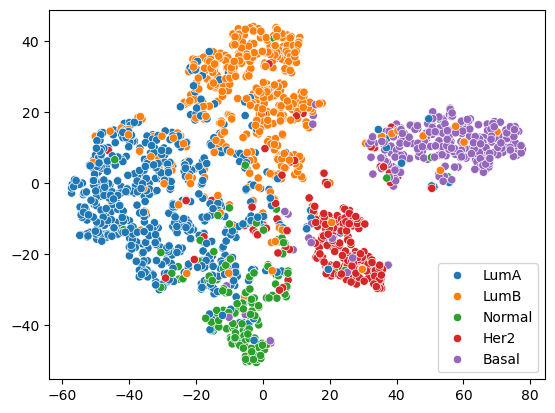

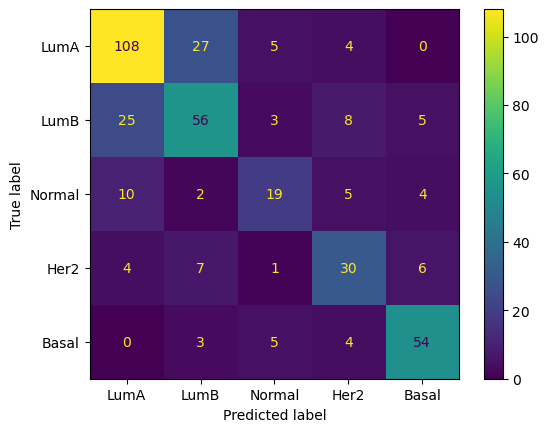

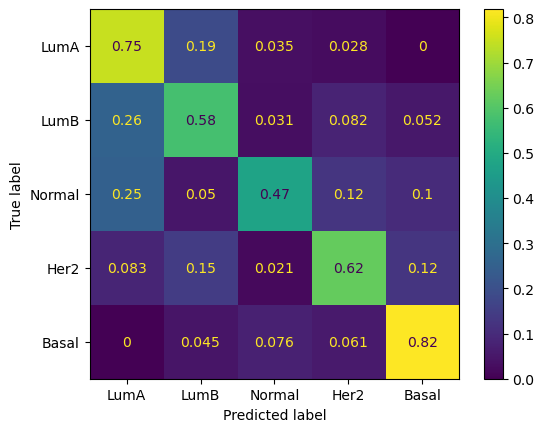

0.6504419851673064

In [33]:
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    pred, h = model(data.x, data.edge_index)
    pred = pred.argmax(dim=-1)

    f1 = f1_score(
                data.y[data.mask_test].cpu().numpy(), pred[data.mask_test].cpu().numpy(), average="macro"
            )
    plot_latent_space(h.cpu().numpy(), data.pam50)
    plot_confusion_matrix(data.y[data.mask_test].cpu().numpy(), pred[data.mask_test].cpu().numpy(), data.pam50_labels, normalize=None)
    plot_confusion_matrix(data.y[data.mask_test].cpu().numpy(), pred[data.mask_test].cpu().numpy(), data.pam50_labels, normalize="true")
    return f1

evaluate(model, data)